In [32]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.cluster import KMeans,MeanShift,MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.compose import ColumnTransformer

import category_encoders as ce

In [33]:
#read in data
customers = pd.read_csv('./data/customers.csv')
customers.head()

,customer_ID,sex,registration_date,first_rent_date,customer_age
0,1,Woman,01.09.20 00:14,01.09.20 01:47,34
1,2,man,31.08.20 21:13,31.08.20 23:50,28
2,3,man,31.08.20 20:53,31.08.20 23:06,23
3,4,Woman,31.08.20 20:50,31.08.20 23:45,24
4,5,Woman,31.08.20 20:45,31.08.20 23:33,28


In [34]:
customers.dtypes

customer_ID           int64
sex                  object
registration_date    object
first_rent_date      object
customer_age          int64
dtype: object

In [35]:
print('The number of customers in customers data is {}'.format(customers.shape[0]))

The number of customers in customers data is 10000


In [36]:
#convert registration_date and first_rent_date to datetime format

customers[["registration_date","first_rent_date"]] = customers[["registration_date","first_rent_date"]].apply(pd.to_datetime)

In [37]:
rentals = pd.read_csv('./data/rentals.csv')
rentals.head()

,place,package,rent_id,customer_ID,rental_start_date,distance,duration,price
0,Berlin,pay_per_minute,d9b784a3-4,17091,15.04.20,2,7,2.07
1,Hamburg,pay_per_minute,0906b4a9-e,66145,15.02.20,4,12,2.38
2,Hamburg,pay_per_minute,43d2d8c0-6,62554,24.07.20,4,15,4.10
3,Berlin,pay_per_minute,b92469d5-0,31508,13.01.20,10,27,5.40
4,Hamburg,pay_per_minute,b3c72862-3,66064,08.06.20,2,8,1.79


In [38]:
print('The number of rents in rentals data is {}'.format(rentals.shape[0]))

The number of rents in rentals data is 100000


#### Feature Engineering: Creating New Features

In [39]:
#merge the 2 dataframe's together.

df = rentals.merge(customers, on='customer_ID')
df.head()

,place,package,rent_id,customer_ID,rental_start_date,distance,duration,price,sex,registration_date,first_rent_date,customer_age
0,Hamburg,pay_per_minute,4071ef0d-6,4729,22.07.20,7,28,6.23,Woman,2020-05-25 01:15:00,2020-05-29 17:13:00,23
1,Hamburg,pay_per_minute,331ba874-8,4729,12.08.20,4,11,2.64,Woman,2020-05-25 01:15:00,2020-05-29 17:13:00,23
2,Hamburg,pay_per_minute,4071ef0d-6,4729,22.07.20,7,28,6.23,Woman,2020-05-25 01:15:00,2020-05-29 17:13:00,23
3,Hamburg,pay_per_minute,fbcb4dfb-6,4729,26.08.20,43,75,19.21,Woman,2020-05-25 01:15:00,2020-05-29 17:13:00,23
4,Hamburg,pay_per_minute,38875c74-d,4729,24.07.20,16,29,7.69,Woman,2020-05-25 01:15:00,2020-05-29 17:13:00,23


In [41]:
#remove all drivers above the age of 80

df = df[df.customer_age <= 80]

In [42]:
#convert rental_start_date,registration_datetime_local, Rental_First_Datetime_local to date-type

df[["rental_start_date", "registration_date", "first_rent_date"]] = df[["rental_start_date", "registration_date", "first_rent_date"]].apply(pd.to_datetime,errors='coerce')


#extract rental_start_month and rental_start_year from rental_start_date
df['rental_start_month'] = pd.DatetimeIndex(df["rental_start_date"]).month
df['rental_start_year'] = pd.DatetimeIndex(df["rental_start_date"]).year

/Users/admin/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/var/folders/r2/npg0bdw94_x2md_1zwp1191h0000gn/T/ipykernel_2768/3159949058.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rental_start_month'] = pd.DatetimeIndex(df["rental_start_date"]).month
/var/folders/r2/npg0bdw94_x2md_1zwp1191h0000gn/T/ipykernel_2768/3159949058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [43]:
print('The latest date in the dataframe is {}'.format(df["rental_start_date"].max()))
print('The earliest date in the dataframe is {}'.format(df["rental_start_date"].min()))

The latest date in the dataframe is 2020-12-08 00:00:00
The earliest date in the dataframe is 2020-01-02 00:00:00


In [44]:
#calculate the monthly average rent count from df
df_info = df.groupby(['customer_ID','rental_start_month']).agg({'rent_id':'nunique'}).reset_index(drop=False).groupby('customer_ID')['rental_start_month'].sum()/12

#calculate the monthly revenue from each customer from df
df_info_mean = df.groupby(['customer_ID','rental_start_month']).agg({'price':'mean',
                                                                    'duration':'mean'}).reset_index(drop=False)
                          
#merge new info with customer data    
customers = customers.merge(df_info,on='customer_ID').merge(df_info_mean,on='customer_ID').rename(columns=
                                                                                                  {'rental_start_month_x':'monthly_rent_average',
                                                                                                   'price':'mean_monthly_rental_revenue',
                                                                                                  'duration':'mean_monthly_rental_duration'})

In [45]:
#create day distance registration to rental
customers['registration_to_rental_days'] = (customers['registration_date'] - customers['first_rent_date']).dt.days

#drop all datetime columns and ID columns (rental_ID & customer_ID)
customers_ = customers.drop(['rental_start_month_y','registration_date','first_rent_date','customer_ID'],axis=1)

customers_.head()

,sex,customer_age,monthly_rent_average,mean_monthly_rental_revenue,mean_monthly_rental_duration,registration_to_rental_days
0,Woman,34,0.666667,3.8,32.0,-1
1,man,19,0.666667,0.0,10.0,-1
2,man,37,0.666667,0.0,25.0,-1
3,man,41,0.666667,0.0,20.0,-1
4,man,22,0.666667,0.0,43.0,-1


In [46]:
#save df to disk
#df.to_csv('./data/df_dashboard.csv',index=False)

#### Model Development

In [13]:
#initialize the ordinal_encoder for Gender
ce_ord = ce.OrdinalEncoder(cols = ['sex'])

#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['customer_age', 'mean_monthly_rental_revenue','mean_monthly_rental_duration','registration_to_rental_days'])
    ], remainder='passthrough')

In [14]:
#instantiate the clustering model
kmeans = KMeans(n_clusters = 5,algorithm='full')

#build a pipeline for the kmeans clustering model
pipe_kmeans = Pipeline([('ordinal_encode',ce_ord),
                        ('transformer', ct),
                        ('kmeans', kmeans)])


#fit the k-means model
pipe_kmeans.fit(customers_)

#assign a cluster to each customer using the kmeans cluster
customer_cluster_kmeans = pipe_kmeans.predict(customers_)

In [15]:
#retrieve and count of each cluster group of the kmeans cluster
unique, counts = np.unique(customer_cluster_kmeans, return_counts=True)
dict(zip(unique, counts))

{0: 3332, 1: 869, 2: 1773, 3: 1570, 4: 571}

In [16]:
#build a mean MiniBatchKMeans model
minibatch = MiniBatchKMeans(n_clusters=5,batch_size=1000)

#build a pipeline for the kmeans clustering model
pipe_minibatch = Pipeline([('ordinal_encode',ce_ord),
                           ('transformer', ct),
                          ('minbatch', minibatch)])


#fit the mean shift model
pipe_minibatch.fit(customers_)

#assign a cluster to each customer using the shift model
customer_cluster_minibatch = pipe_minibatch.predict(customers_)

In [17]:
#retrieve and count of each cluster group of the minibatch KMeans model
unique, counts = np.unique(customer_cluster_minibatch, return_counts=True)
dict(zip(unique, counts))

{0: 1009, 1: 3332, 2: 1594, 3: 611, 4: 1569}

In [18]:
#plug in the clusters generated by the kmeans clustering algorithm
customers['customer_group'] = customer_cluster_kmeans

customers.head(10)

,customer_ID,sex,registration_date,first_rent_date,customer_age,monthly_rent_average,rental_start_month_y,mean_monthly_rental_revenue,mean_monthly_rental_duration,registration_to_rental_days,customer_group
0,1,Woman,2020-01-09 00:14:00,2020-01-09 01:47:00,34,0.666667,8,3.80,32.0,-1,2
1,6,man,2020-08-31 19:56:00,2020-08-31 21:00:00,19,0.666667,8,0.00,10.0,-1,0
2,8,man,2020-08-31 17:34:00,2020-08-31 18:43:00,37,0.666667,8,0.00,25.0,-1,0
3,23,man,2020-08-30 18:20:00,2020-08-30 20:20:00,41,0.666667,8,0.00,20.0,-1,0
4,24,man,2020-08-30 16:52:00,2020-08-30 18:22:00,22,0.666667,8,0.00,43.0,-1,0
5,32,man,2020-08-30 12:41:00,2020-08-30 16:12:00,27,0.666667,8,7.69,36.0,-1,0
6,35,man,2020-08-30 12:31:00,2020-08-30 20:24:00,32,0.666667,8,7.67,48.0,-1,0
7,38,Woman,2020-08-30 11:54:00,2020-08-30 12:26:00,24,0.666667,8,0.00,1.0,-1,2
8,41,man,2020-08-30 10:45:00,2020-08-30 11:59:00,33,0.666667,8,0.00,40.0,-1,0
9,43,man,2020-08-30 10:05:00,2020-08-31 09:45:00,52,0.666667,8,4.53,30.0,-1,0


In [19]:
customers.customer_group.value_counts()

0    3332
2    1773
3    1570
1     869
4     571
Name: customer_group, dtype: int64

#### Explore Model Results

In [20]:
#Explore the model clustering results - customer groups on monthly_rent_average and registration_to_rental_days
np.round(customers.groupby(['customer_group'])[['monthly_rent_average','registration_to_rental_days']].describe(),2)

monthly_rent_average                                            \
                              count  mean   std   min   25%   50%   75%   max   
customer_group                                                                  
0                            3332.0  0.67  0.35  0.08  0.42  0.67  0.92  1.33   
1                             869.0  2.08  0.50  1.42  1.67  2.00  2.50  3.17   
2                            1773.0  0.68  0.34  0.08  0.50  0.67  0.92  1.33   
3                            1570.0  2.03  0.45  1.42  1.67  1.92  2.33  3.17   
4                             571.0  4.02  0.75  3.08  3.42  3.83  4.50  6.42   

               registration_to_rental_days                                     \
                                     count    mean      std    min   25%  50%   
customer_group                                                                  
0                                   3332.0   77.57   802.69 -340.0 -13.0 -1.0   
1                                    869.0   -9.30    79.74 -321.0 -14.0 -1.0   
2                                   1773.0   -8.06    76.74 -339.0 -19.0 -1.0   
3                                   1570.0  177.73  1168.51 -274.0 -28.5 -1.0   
4                                    571.0  159.25  1151.76 -294.0  -9.0 -1.0   

                             
                75%     max  
customer_group               
0              -1.0  7641.0  
1              -1.0   265.0  
2              -1.0   333.0  
3              -1.0  7641.0  
4              -1.0  7412.0

In [21]:
#Explore the model clustering results - customer groups on mean_monthly_rental_revenue and mean_monthly_rental_duration
np.round(customers.groupby(['customer_group'])[['mean_monthly_rental_revenue','mean_monthly_rental_duration']].describe(),2)

mean_monthly_rental_revenue                                  \
                                     count   mean     std  min   25%   50%   
customer_group                                                               
0                                   3332.0  14.15  189.97  0.0  1.93  4.31   
1                                    869.0   7.57   13.70  0.0  3.25  4.91   
2                                   1773.0   9.21   52.26  0.0  1.93  4.40   
3                                   1570.0   7.71   12.80  0.0  2.81  4.79   
4                                    571.0   7.56   16.30  0.0  2.88  4.59   

                               mean_monthly_rental_duration                   \
                 75%       max                        count    mean      std   
customer_group                                                                 
0               7.97  10327.59                       3332.0  173.14  1998.48   
1               8.18    336.24                        869.0   44.98   122.32   
2               7.73   1759.86                       1773.0  103.87  1303.83   
3               8.16    249.64                       1570.0   53.05   161.50   
4               7.70    343.96                        571.0  119.31  1749.09   

                                                 
                min   25%    50%   75%      max  
customer_group                                   
0               0.0  14.0  22.42  38.0  48296.0  
1               0.0  15.0  22.00  35.0   2618.0  
2               0.0  15.0  23.00  37.0  48019.0  
3               0.0  14.0  21.17  36.0   2884.0  
4               1.0  14.0  20.50  34.0  41751.0

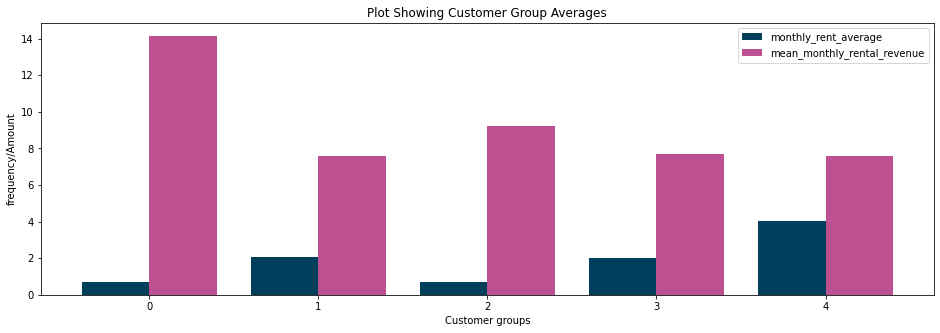

In [22]:
#visualizations

#calculate the averages over the groups
mean_df = customers.groupby(['customer_group'])['monthly_rent_average','registration_to_rental_days','mean_monthly_rental_revenue','mean_monthly_rental_duration'].mean().reset_index()


#plot the monthly_rent_average and mean_monthly_rental_revenue
plt.figure(figsize = (16,5))

X = list(mean_df.customer_group)
rentals = list(mean_df.monthly_rent_average)
revenue = list(mean_df.mean_monthly_rental_revenue)
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, rentals, 0.4, label = 'monthly_rent_average',color='#003f5c')
plt.bar(X_axis + 0.2, revenue, 0.4, label = 'mean_monthly_rental_revenue',color='#bc5090')

plt.xticks(X_axis, X)
plt.xlabel("Customer groups")
plt.ylabel("frequency/Amount")
plt.title("Plot Showing Customer Group Averages")
plt.legend()
plt.show()

Note: (**group numbers in the statement below might vary due to model re-build but group dynamics are consistent)

#### Observations:
1. Group 0 contains customers with less ride frequency but with the highest mean monthly rental revenue.
2. Group 4 contains who ride often(to work,school) but possibly for short distances.
3. While Group 1 and Group 3 seem similar in both the mean_monthly_rental_avenue & monthly_rent_average.

#### Determine Optimal Number of Clusters

In [23]:
#copy the customers_ into optimize_df
optimize_df = customers_.copy()

#transform the sex column
optimize_df = ce_ord.fit_transform(optimize_df) 

#column transformer
optimize_df = ct.fit_transform(optimize_df) 

##### Elbow Method

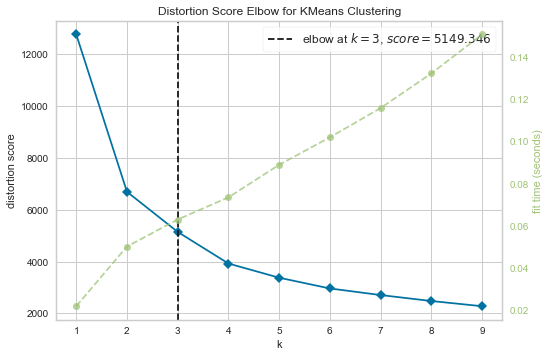

In [24]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(pipe_kmeans[2], k=(1,10))  #pipe_kmeans[2] is the model

visualizer.fit(optimize_df)

visualizer.show()

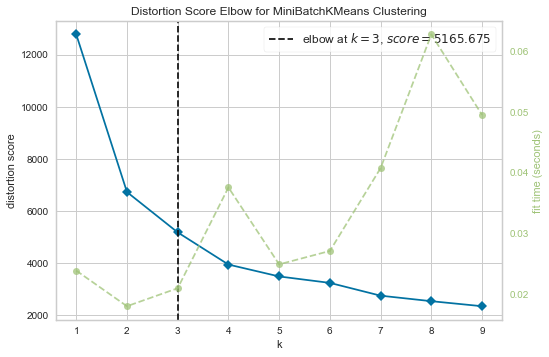

In [25]:
visualizer = KElbowVisualizer(pipe_minibatch[2], k=(1,10))  #pipe_kmeans[2] is the model

visualizer.fit(optimize_df)

visualizer.show()

##### Silhouette Coefficient

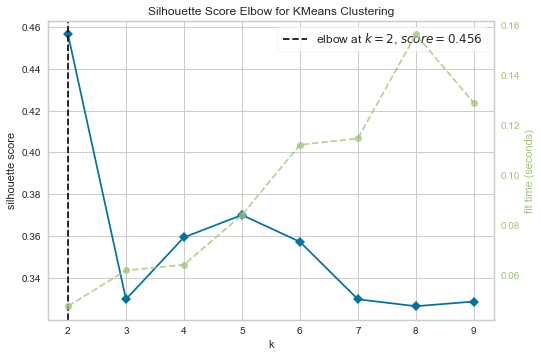

In [26]:
visualizer_sil = KElbowVisualizer(pipe_kmeans[2], k=(2,10),metric='silhouette', timings= True)  #pipe_kmeans[2] is the model

visualizer_sil.fit(optimize_df)

visualizer_sil.show()

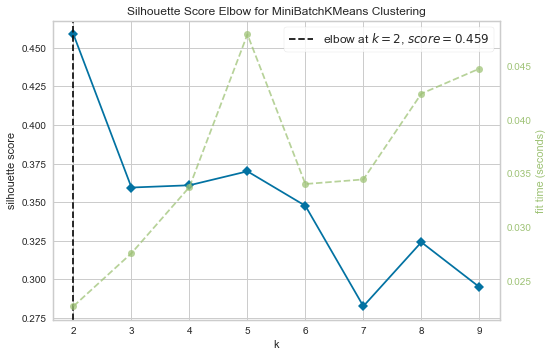

In [27]:
visualizer_sil = KElbowVisualizer(pipe_minibatch[2], k=(2,10),metric='silhouette', timings= True)  #pipe_kmeans[2] is the model

visualizer_sil.fit(optimize_df)

visualizer_sil.show()

##### Calinski-Harabasz Index

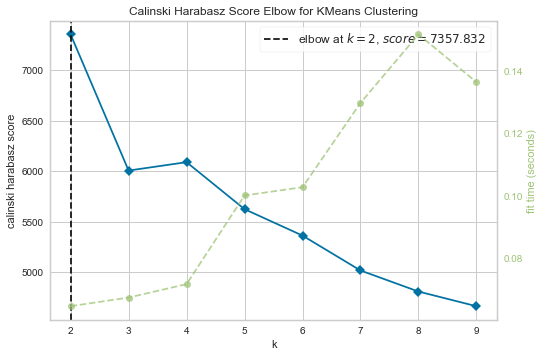

In [31]:
visualizer_cal = KElbowVisualizer(pipe_kmeans[2], k=(2,10),metric='calinski_harabasz', timings= True)  #pipe_kmeans[2] is the model

visualizer_cal.fit(optimize_df)

visualizer_cal.show()

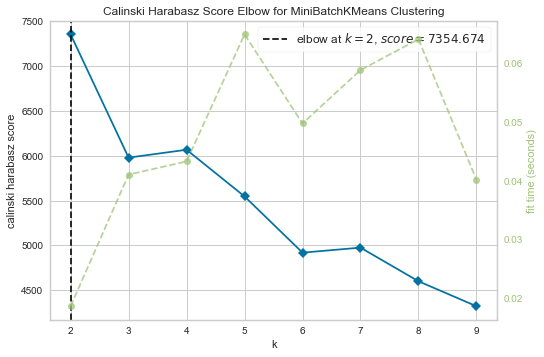

In [29]:
visualizer_cal = KElbowVisualizer(pipe_minibatch[2], k=(2,10),metric='calinski_harabasz', timings= True)  #pipe_kmeans[2] is the model

visualizer_cal.fit(optimize_df)

visualizer_cal.show()